In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy import spatial
import random
import cv2

In [2]:
target_image_path = 'images/SampleImage.webp'
tile_images_path = ['Mosaic-Images/47912.png',
 'Mosaic-Images/47906.png',
 'Mosaic-Images/47090.png',
 'Mosaic-Images/47084.png',
 'Mosaic-Images/47709.png',
 'Mosaic-Images/47053.png',
 'Mosaic-Images/47735.png',
 'Mosaic-Images/47721.png',
 'Mosaic-Images/47047.png',
 'Mosaic-Images/47292.png']

divisions = 20

In [3]:
def resize_image(img : Image, size : tuple) -> np.ndarray:
        resz_img = ImageOps.fit(img, size, Image.LANCZOS, centering=(0.5, 0.5))
        return np.array(resz_img)

def blend_image(region, tile, opacity_percent):
    #print('region ', region.shape)
    #print('tile ', tile.shape)
    
#     region_avg_color = np.mean(region, axis=(0, 1))
#     tile_avg_color = np.mean(tile, axis=(0, 1))
#     color_diff = np.linalg.norm(region_avg_color - tile_avg_color)
    alpha = opacity_percent/100 # 1.0 - (color_diff / 255.0)
    blended_region = (alpha * region + (1.0 - alpha) * tile).astype(np.uint8)
    return blended_region


In [4]:
import numpy as np

def find_closest_images(given_image, image_list, k=3):
    mse_values = [np.mean((given_image - img) ** 2) for img in image_list]
    closest_indices = np.argsort(mse_values)[:k]
    closest_images = [image_list[idx] for idx in closest_indices]
    return random.choice(closest_images)

In [5]:
def process(target_image_path, tile_images_path, divisions, scale, opacity_percent):
    results = []

    target_image = Image.open(target_image_path)
    original_width, original_height = target_image.size
    target_image = resize_image(target_image, (original_height *scale, 
                                                original_height*scale))
    target_image_array = np.array(target_image)
    grid_size = (target_image_array.shape[0]//divisions, target_image_array.shape[1]//divisions)
    combined_image = np.zeros_like(target_image_array)

    for i in range(divisions):
        for j in range(divisions):
            x1, y1 = j * grid_size[1], i * grid_size[0]
            x2, y2 = (j + 1) * grid_size[1], (i + 1) * grid_size[0]
            
            grid_image = target_image_array[y1:y2, x1:x2, :]
            data = {'image': grid_image, 'x1':x1, 'y1':y1, 'y2': y2, 'x2':x2, 'i':i, 'j':j}
            results.append(data)
    
    print(f"Divide images into grid {len(results)}")

    #tile images
    tile_images = []
    for tile_path in tile_images_path:
        im = Image.open(tile_path)
        im = resize_image(im, grid_size)
        tile_images.append(im)
    
    print(f'Resizing tile images {len(tile_images)}')

    for result in results:
        closest_image = find_closest_images(result['image'],
                                            tile_images)
        #blended_image = blend_image(result['image'], closest_image, ope)
        combined_image[result['y1']:result['y2'], result['x1']:result['x2'], :] = blended_image
    
    print(f'combined images')
    
    return results, tile_images, grid_size, Image.fromarray(combined_image)


In [7]:
def process_optimized(target_image_path, tile_images_path, divisions, scale, opacity_percent):
    target_image = Image.open(target_image_path)
    original_width, original_height = target_image.size
    target_image_resized = resize_image(target_image, (original_width * scale, original_height * scale))
    target_image_array = np.array(target_image_resized)
    grid_size = (target_image_array.shape[0] // divisions, target_image_array.shape[1] // divisions)

    # Preprocess tile images
    tile_images = []
    for tile_path in tile_images_path:
        tile_image = Image.open(tile_path)
        tile_image_resized = resize_image(tile_image, grid_size)
        tile_images.append(np.array(tile_image_resized))
        tile_image.close()

    combined_image = np.zeros_like(target_image_array)

    for i in range(divisions):
        for j in range(divisions):
            x1, y1 = j * grid_size[1], i * grid_size[0]
            x2, y2 = (j + 1) * grid_size[1], (i + 1) * grid_size[0]

            grid_image = target_image_array[y1:y2, x1:x2, :]
            closest_image = find_closest_images(grid_image, tile_images)
            blended_image = blend_image(grid_image, closest_image,opacity_percent)
            combined_image[y1:y2, x1:x2, :] = blended_image

    return Image.fromarray(combined_image)


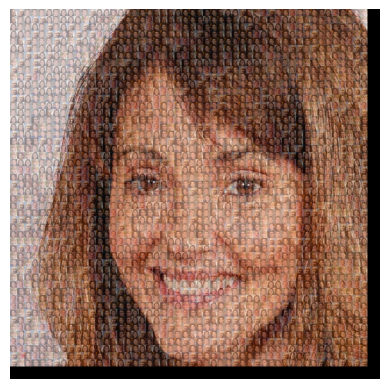

In [8]:
final_image = process_optimized(target_image_path, tile_images_path, 50,1,60)
final_image.save
plt.imshow(final_image)
plt.axis('off')  # Turn off axis labels for clarity
plt.show()

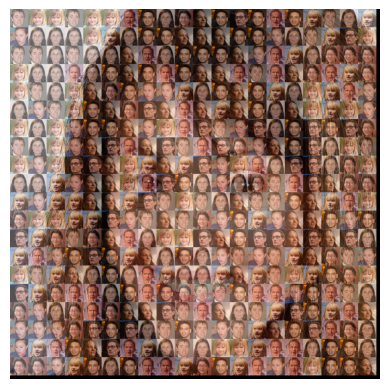

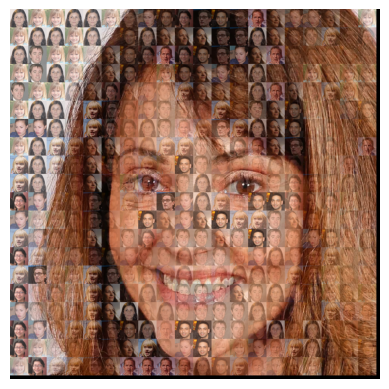

In [66]:
plt.imshow(final_image)
plt.axis('off')  # Turn off axis labels for clarity
plt.show()